In [1]:
# Change working directory
%cd ..

/Users/balthazardonon/Documents/PhD/Code/GraphNeuralSolver


In [71]:
import os

import numpy as np
import tensorflow as tf
import networkx as nx
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

In [3]:
data_directory = 'datasets/spring/default'
mode = 'train'

# Import numpy dataset
A = np.load(os.path.join(data_directory, 'A_'+mode+'.npy'))
B = np.load(os.path.join(data_directory, 'B_'+mode+'.npy'))
X = np.load(os.path.join(data_directory, 'X_'+mode+'.npy'))

## Data dimension

We define $G = (A,B)$ to be a hypergraph. Let $n$ be the amount of nodes in the hypergraph. Each edge in $A$ is defined by a $d_{in,A}$-dimensional vector.

\begin{align}
    A \in ( \mathbb{R}^{d_{in,A}} )^{n^2}
\end{align}

Each node is defined by a $d_{in,B}$-dimensional vector.

\begin{align}
    B \in ( \mathbb{R}^{d_{in,B}} )^{n^1}
\end{align}

In the linear case, we have $d_{in,A}=1$ and $d_{in,B}=1$.Since $A$ is quite sparse in most of the problems we are actually interested in, we use a sparse description of it, as can be shown:

In [91]:
print('A has shape : {}'.format(A.shape))
print('B has shape : {}'.format(B.shape))
print('')
print('There are {} samples'.format(A.shape[0]))
print('There are {} directed edges per sample'.format(A.shape[1]))
print('There are {} nodes per sample'.format(B.shape[1]))
print('')
print('The dimension of each edge is {}'.format(A.shape[2]-2))
print('The dimension of each node is {}'.format(B.shape[2]))

A has shape : (1000, 40, 3)
B has shape : (1000, 10, 1)

There are 1000 samples
There are 40 directed edges per sample
There are 10 nodes per sample

The dimension of each edge is 1
The dimension of each node is 1


## Matrix A

The matrix A contains all the information about the interactions between nodes.

Here is a typical sample of matrix $A$.
Each row is defined by the tuple $(i, j, A_{ij})$. Since $A_{ij}$ has $d_{in,A}$-dimensions, this makes every row $(d_{in,A}+2)$-dimensional.

In [86]:
print(A[0])

[[ 1.     0.    -0.844]
 [ 2.     0.    -0.187]
 [ 3.     0.    -0.687]
 [ 4.     2.    -0.5  ]
 [ 5.     0.    -0.48 ]
 [ 6.     2.    -0.307]
 [ 7.     5.    -0.127]
 [ 8.     2.    -0.227]
 [ 9.     3.    -0.75 ]
 [ 4.     7.    -0.468]
 [ 4.     0.    -0.277]
 [ 2.     0.    -0.689]
 [ 7.     4.    -0.258]
 [ 2.     6.    -0.907]
 [ 8.     7.    -0.942]
 [ 0.     1.     0.   ]
 [ 0.     2.     0.   ]
 [ 0.     3.     0.   ]
 [ 2.     4.    -0.5  ]
 [ 0.     5.     0.   ]
 [ 2.     6.    -0.307]
 [ 5.     7.    -0.127]
 [ 2.     8.    -0.227]
 [ 3.     9.    -0.75 ]
 [ 7.     4.    -0.468]
 [ 0.     4.     0.   ]
 [ 0.     2.     0.   ]
 [ 4.     7.    -0.258]
 [ 6.     2.    -0.907]
 [ 7.     8.    -0.942]
 [ 0.     0.     1.   ]
 [ 1.     1.     0.844]
 [ 2.     2.     2.816]
 [ 3.     3.     1.437]
 [ 4.     4.     1.503]
 [ 5.     5.     0.608]
 [ 6.     6.     1.214]
 [ 7.     7.     1.795]
 [ 8.     8.     1.169]
 [ 9.     9.     0.75 ]]


In [87]:
def sparse_to_matrix(A_sample):
    """
    Converts one sample from sparse to dense
    """
    # Get number of nodes
    n_nodes = int(np.max(A_sample[:,0:2]))+1
    # Initialize zero matrix
    A_mat = np.zeros([n_nodes, n_nodes])
    # For each edge, add value
    for edge in A_sample:
        A_mat[int(edge[0]), int(edge[1])] += edge[2]
    return A_mat
A_mat = sparse_to_matrix(A[0])

Here is the same object but represented as a dense matrix:

In [88]:
print(A_mat)

[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.844  0.844  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.876  0.     2.816  0.    -0.5    0.    -1.214  0.    -0.227  0.   ]
 [-0.687  0.     0.     1.437  0.     0.     0.     0.     0.    -0.75 ]
 [-0.277  0.    -0.5    0.     1.503  0.     0.    -0.726  0.     0.   ]
 [-0.48   0.     0.     0.     0.     0.608  0.    -0.127  0.     0.   ]
 [ 0.     0.    -1.214  0.     0.     0.     1.214  0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.726 -0.127  0.     1.795 -0.942  0.   ]
 [ 0.     0.    -0.227  0.     0.     0.     0.    -0.942  1.169  0.   ]
 [ 0.     0.     0.    -0.75   0.     0.     0.     0.     0.     0.75 ]]


And here is a graphical representation of this system. Note that the graph is drawn as undirected, while it is actually directed (see matrix above)

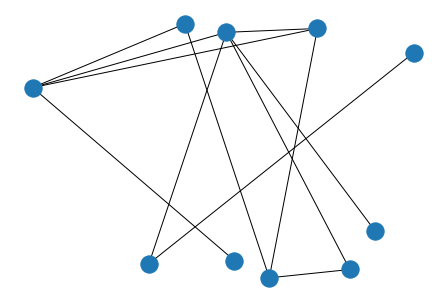

In [84]:
G=nx.from_numpy_matrix(A_mat)
pos = nx.spring_layout(G)
nx.draw(G, pos=pos)
plt.show()

## Matrix B

Matrix $B$ is simpler than $A$. For each node, it contains a $d_{in,B}$-dimensional information.

Here is a typical example of matrix $B$

In [90]:
print(B[0])

[[6.319]
 [0.966]
 [0.254]
 [0.706]
 [0.33 ]
 [0.613]
 [0.735]
 [0.621]
 [0.183]
 [0.622]]
